In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
from matplotlib import gridspec
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

from mpl_toolkits import mplot3d

/Users/sophia/.local/venv/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [40]:
from multiprocessing import Pool
import numpy as np
import astropy.stats
import supercubos
import corner
from sklearn.gaussian_process.kernels import Matern
import emcee
import maszcal.lensing
import maszcal.emulate
import maszcal.interpolate
import maszcal.likelihoods
import maszcal.fitutils
from maszcal.interp_utils import cartesian_prod

In [4]:
zs = np.linspace(0, 1, 12)
mus = np.linspace(np.log(5e13), np.log(5e15), 30)

model = maszcal.lensing.BaryonCmShearModel(
    mu_bins=mus,
    redshift_bins=zs,
)

rs = np.logspace(-1, 1, 30)

In [5]:
param_mins = np.array([0.1, 0.1, -2]) #alpha, beta, gamma, a_sz
param_maxes = np.array([6, 8.1, 2])

lh = supercubos.LatinSampler().get_lh_sample(param_mins, param_maxes, 200)

alphas = lh.T[0]
betas = lh.T[1]
gammas = np.array([0.2])
a_szs = lh.T[2]

esds = model.stacked_delta_sigma(rs, alphas, betas, gammas, a_szs)
data = rs[:, None] * esds

emulator = maszcal.emulate.PcaEmulator.create_from_data(
    coords=lh,
    data=data,
    interpolator_class=maszcal.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': Matern()}
)

In [6]:
rand = supercubos.LatinSampler().get_rand_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=140,
)

alphas_check = rand.T[0]
betas_check = rand.T[1]
gammas_check = gammas
a_szs_check = rand.T[2]

esds_check = model.stacked_delta_sigma(rs, alphas_check, betas_check, gammas_check, a_szs_check)
data_check = rs[:, None] * esds_check

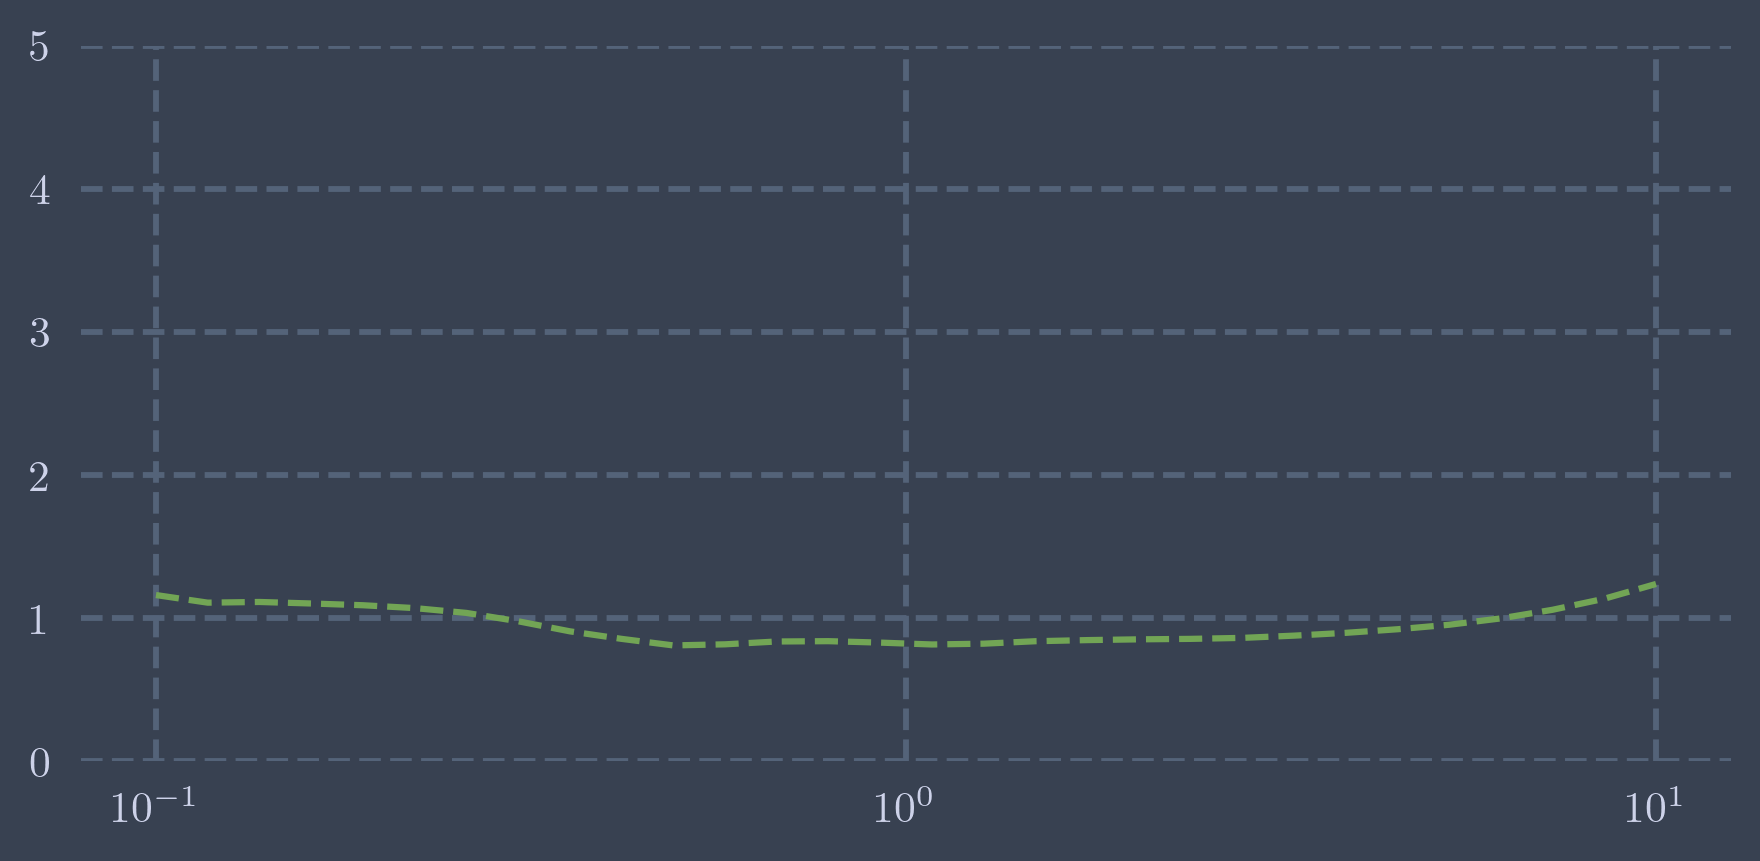

In [7]:
emulated_data = emulator(rand)
errs = (emulated_data - data_check)/data_check

colors = ['#72a555', '#ab62c0', '#c57c3c', '#638ccc', '#ca5670']

plt.plot(rs, 100*np.abs(errs).mean(axis=-1), color=colors[0], linestyle='--')
plt.ylim((0, 5))
plt.xscale('log')
plt.gcf().set_size_inches(6, 3)
pass

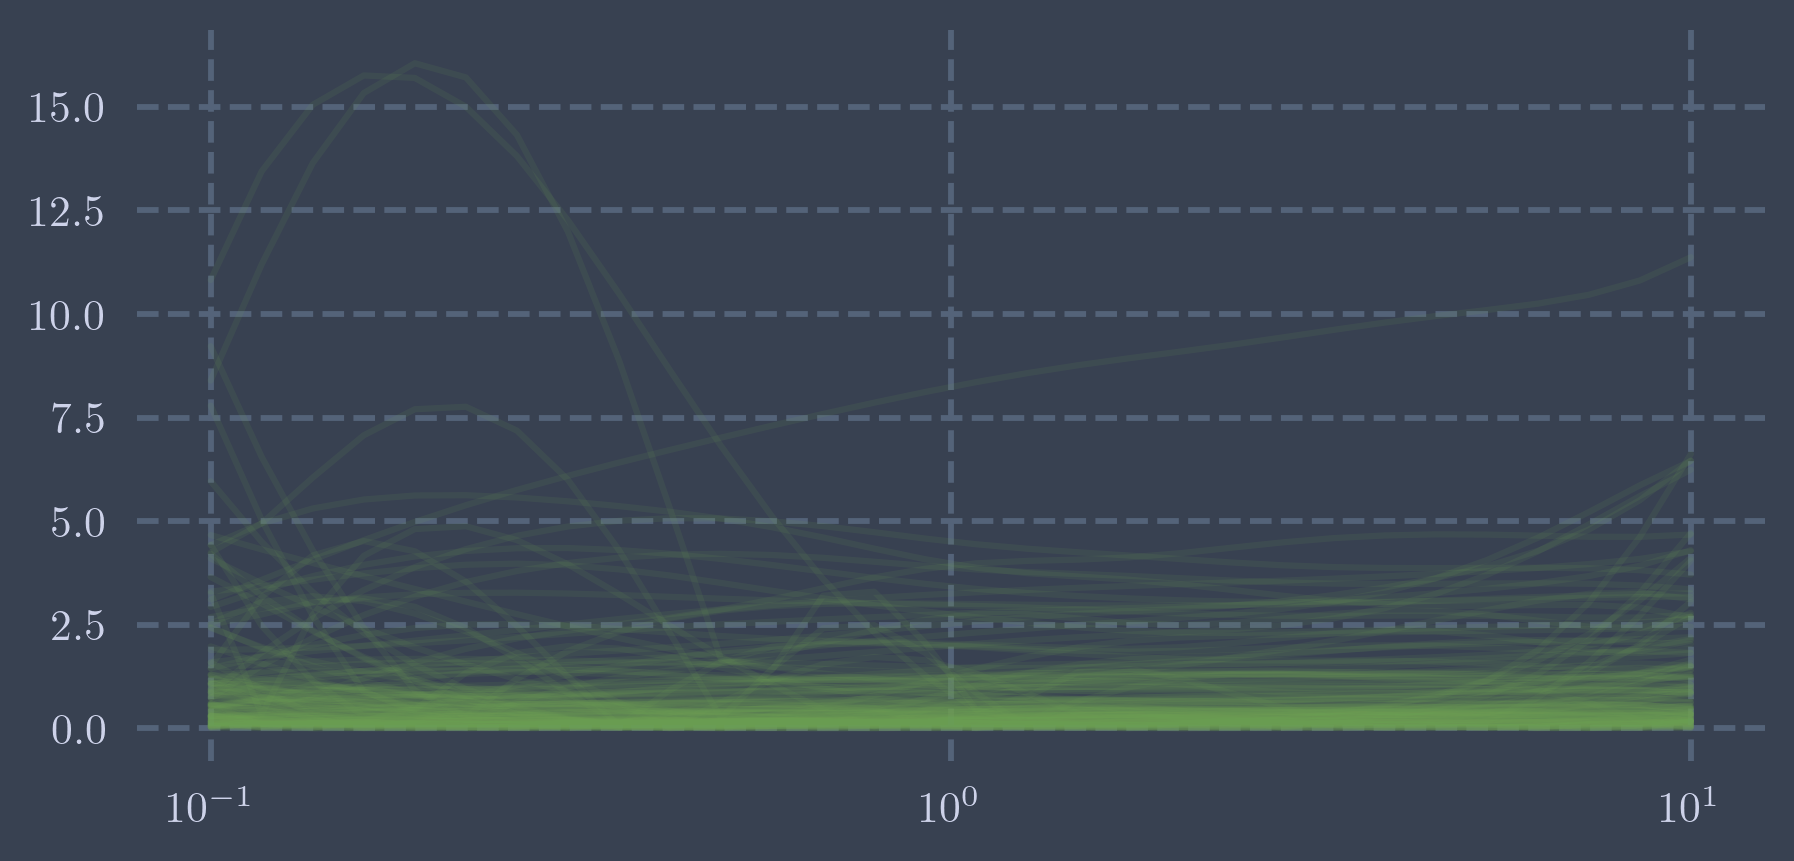

In [8]:
plt.plot(rs, 100*np.abs(errs), color=colors[0], linestyle='-', alpha=0.1)
plt.xscale('log')
plt.gcf().set_size_inches(6, 3)
pass

In [9]:
DATA_DIR = '../data/NBatta2010/single-mass-bin-fits/'
nfw_best_fits = np.load(DATA_DIR + 'nfw-free-c_fixed-true-mass_2020-05-19-122649.npy')
bary_best_fits = np.load(DATA_DIR + 'bary-free-c_fixed-true-mass_2020-05-19-125947.npy')
bary_cm_best_fits = np.load(DATA_DIR + 'bary-cm_fixed-true-mass_2020-05-19-133304.npy')

gammas_stack = np.array([0.2])
a_szs_stack = np.array([0])

In [10]:
param_data = bary_cm_best_fits.reshape(2, -1)
param_data = param_data[(0.1 < param_data) & (param_data < 9)].reshape(2, -1)

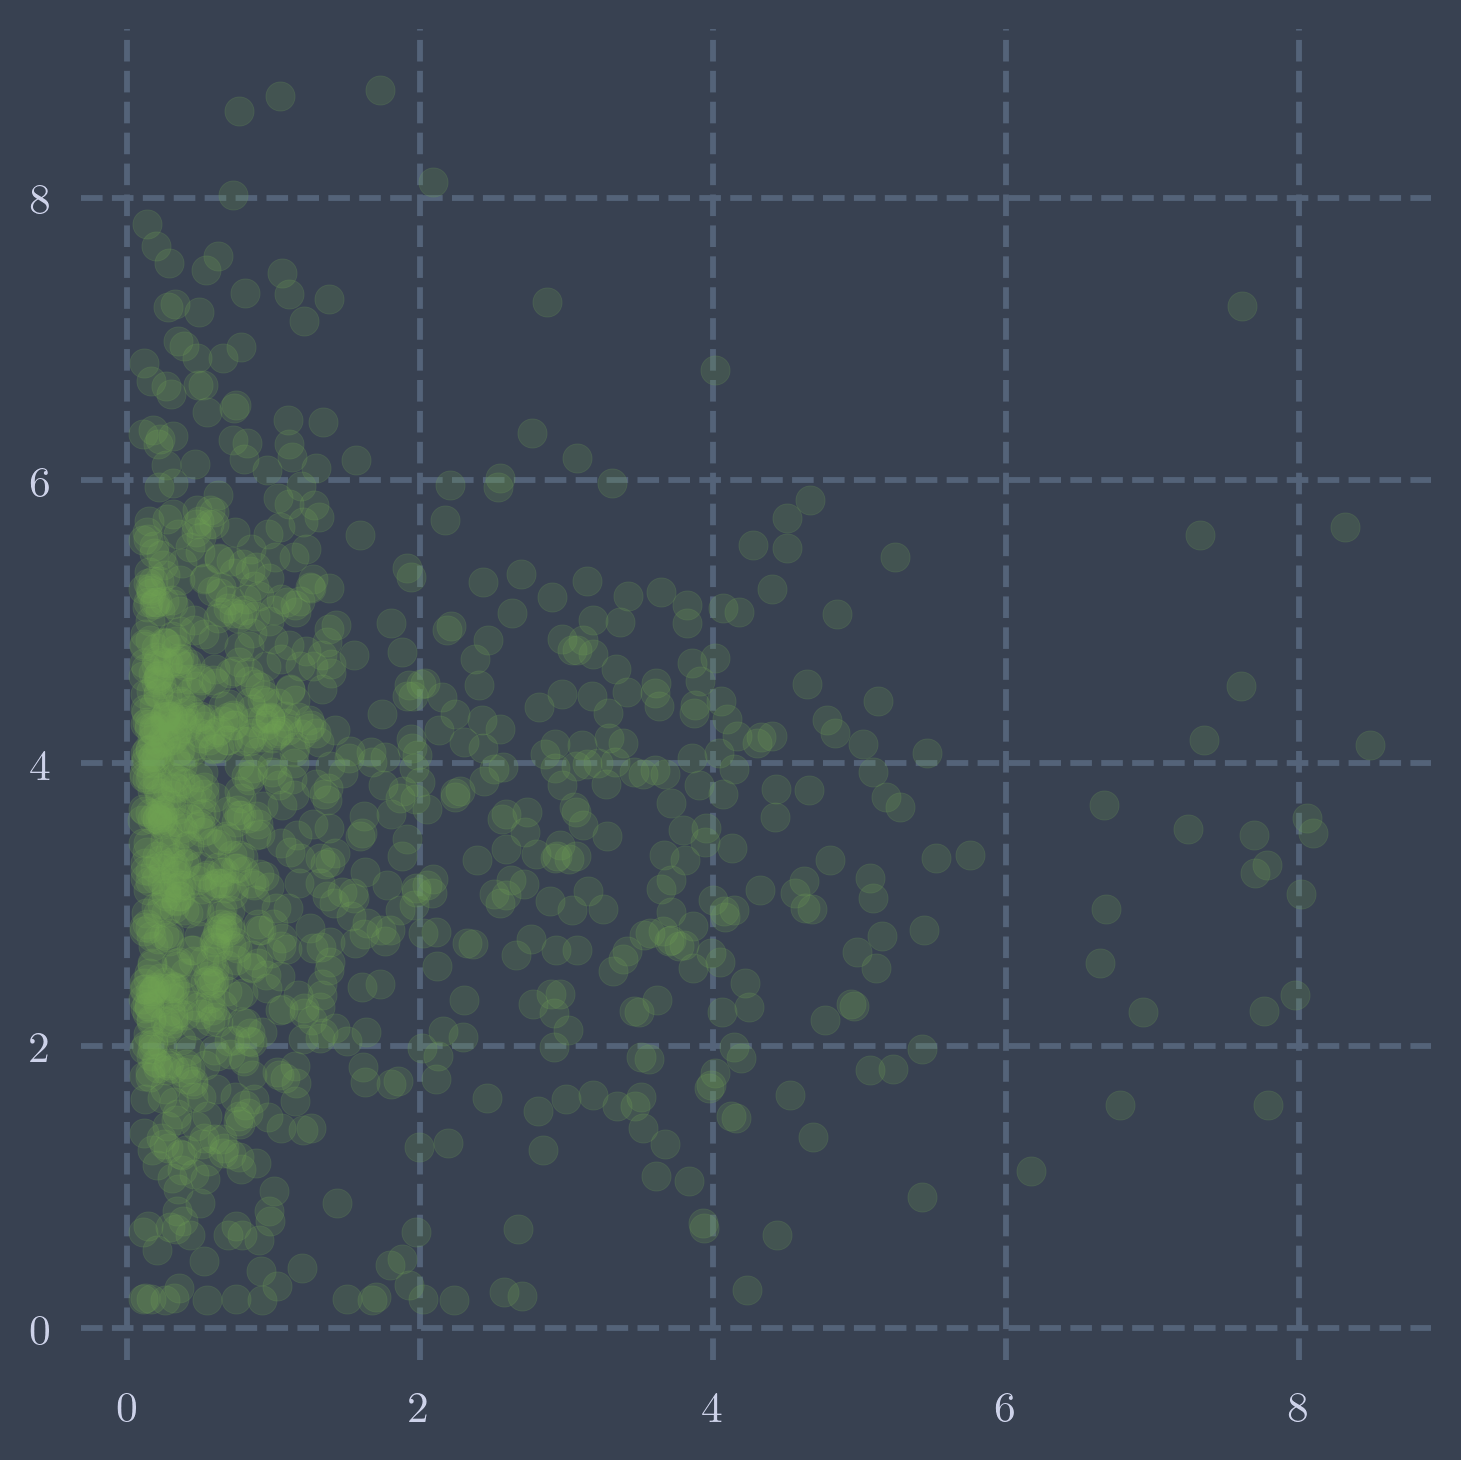

In [11]:
plt.scatter(param_data[0, :], param_data[1, :], color=colors[0], alpha=0.2)
plt.gcf().set_size_inches(5, 5)
pass

In [23]:
resampled_data = np.squeeze(
    astropy.stats.bootstrap(param_data.T, bootnum=80, samples=1)
).T

alphas_stack = resampled_data[0, :]
betas_stack = resampled_data[1, :]

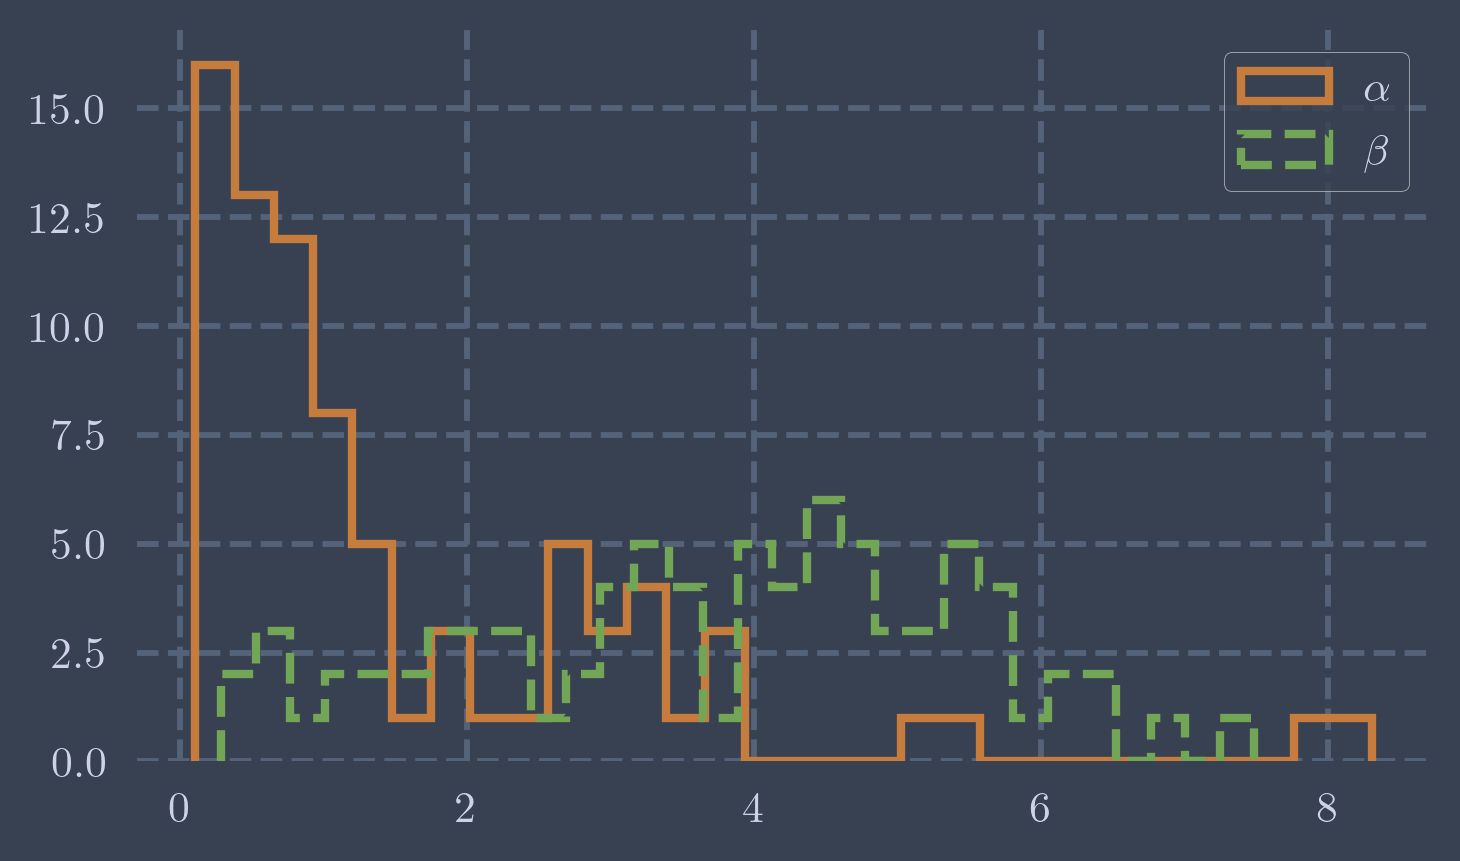

In [24]:
plt.hist(alphas_stack, bins=30, histtype='step', linewidth=2,
         color=colors[2], label=r'$\alpha$')
plt.hist(betas_stack, bins=30, histtype='step', linewidth=2,
         color=colors[0], linestyle='--', label=r'$\beta$')
plt.gcf().set_size_inches(5, 3)
plt.legend(loc='best')
#plt.savefig('../figs/stack/param_hist.pdf')
pass

In [25]:
a_szs_stack = np.array([0])
params_stack = np.stack((
    alphas_stack,
    betas_stack,
    np.tile(a_szs_stack, alphas_stack.size),
)).T

params_mean = np.stack((
    np.array([alphas_stack.mean()]),
    np.array([betas_stack.mean()]),
    a_szs_stack,
)).T

In [26]:
pre_stack_esds = emulator(params_stack)

stack_esds_mean = emulator(params_mean)

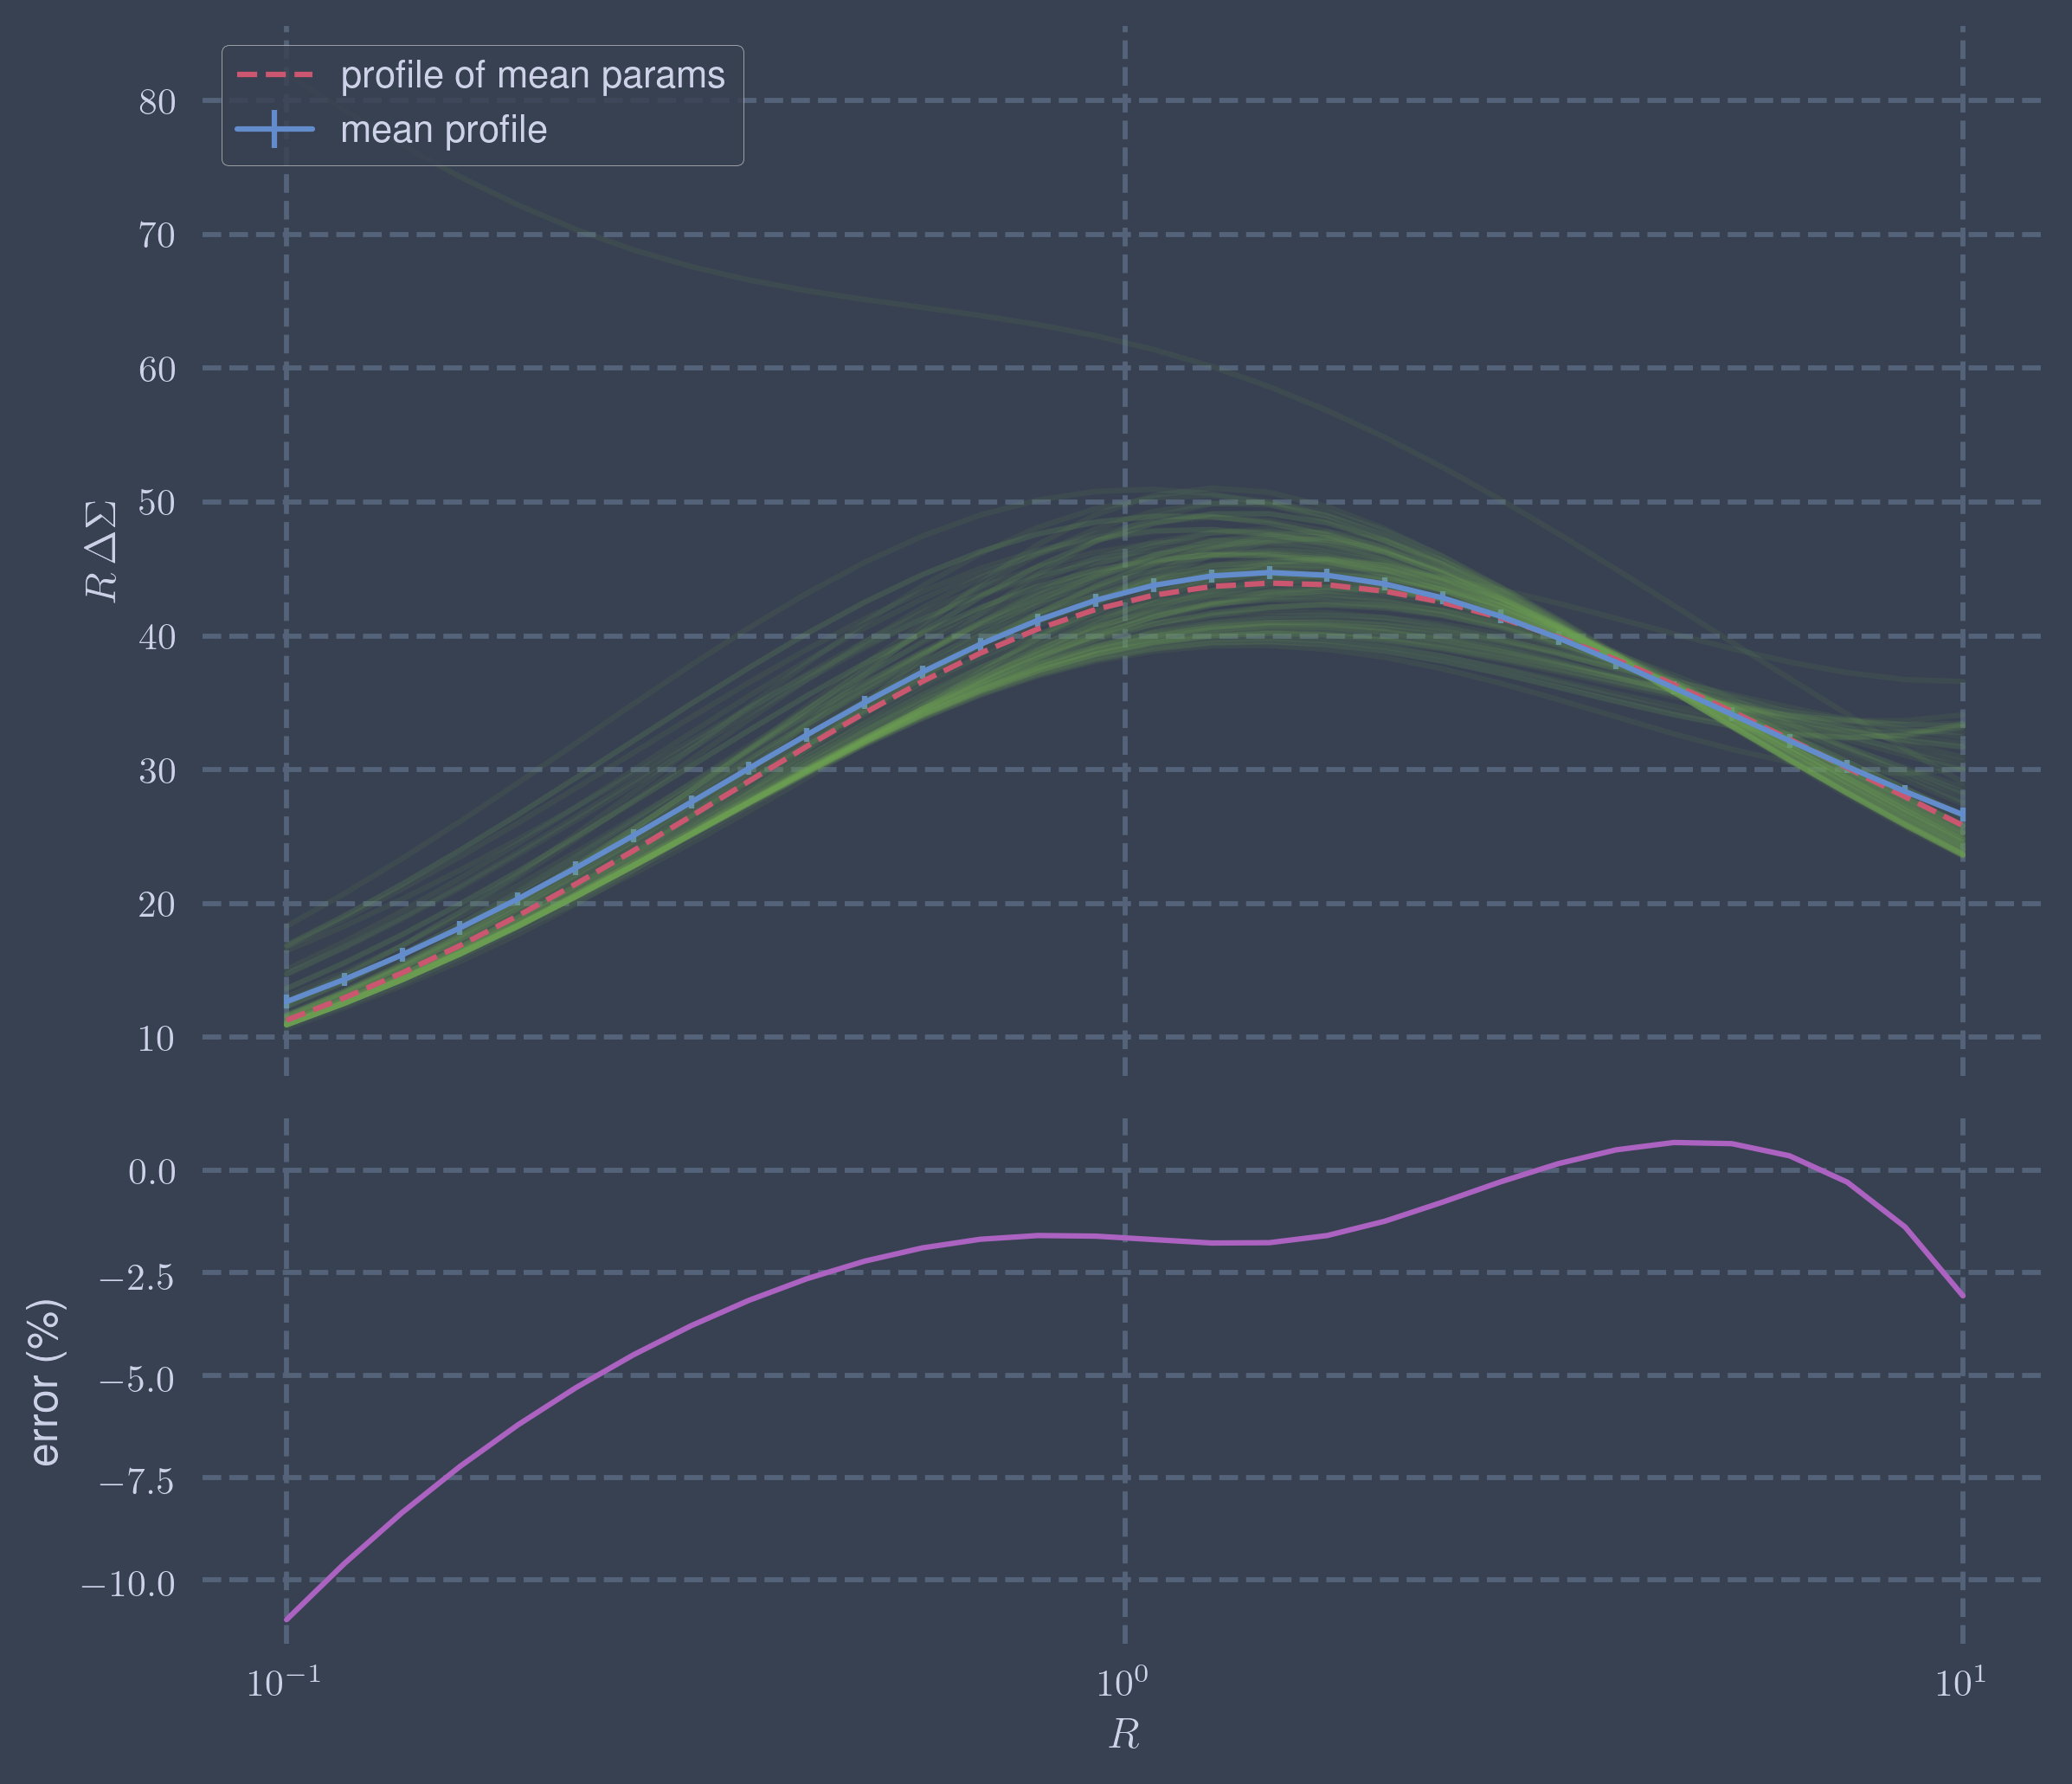

In [27]:
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

fig = plt.figure()
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

cov = np.identity(rs.size)/4

ax1.plot(rs, pre_stack_esds, color=colors[0], alpha=0.1)
ax1.errorbar(rs, pre_stack_esds.mean(axis=-1), yerr=np.diag(np.sqrt(cov)),
             color=colors[3], alpha=1, label='mean profile')
ax1.plot(rs, stack_esds_mean[:, 0], color=colors[4], alpha=1, linestyle='--', 
         label='profile of mean params')
ax1.set_xscale('log')
ax1.set_ylabel(r'$R \, \Delta \Sigma$')

errs = (stack_esds_mean[:, 0] - pre_stack_esds.mean(axis=-1))/pre_stack_esds.mean(axis=-1)

ax2.plot(rs, 100*errs, color=colors[1], alpha=1)
ax2.set_xscale('log')
ax2.set_xlabel(r'$R$')
ax2.set_ylabel('error (\%)')

ax1.legend(loc='upper left')

plt.setp(ax1.get_xticklabels(), visible=False)
#plt.savefig('../figs/stack/result.pdf')
pass

In [28]:
data_stack = pre_stack_esds.mean(axis=-1)
data_mean = stack_esds_mean.flatten()

In [29]:
fisher = 2*np.identity(rs.size)

In [30]:
def log_like(params, data):
    model = emulator(params[None, :]).flatten()
    return maszcal.likelihoods.log_gaussian_shape(model, data, fisher)


def log_prob(params, data):
    if np.all(param_mins < params) and np.all(params < param_maxes):
        return log_like(params, data)
    else:
        return - np.inf

In [31]:
best_fit_stack = maszcal.fitutils.global_minimize(
    lambda p: -log_like(p, data_stack),
    param_mins,
    param_maxes,
    method='global-differential-evolution',
)

In [32]:
best_fit_mean = maszcal.fitutils.global_minimize(
    lambda p: -log_like(p, data_mean),
    param_mins,
    param_maxes,
    method='global-differential-evolution',
)

In [33]:
print(best_fit_stack)
print(best_fit_mean)
print(alphas_stack.mean(), betas_stack.mean())

[ 3.2893482   3.77843213 -0.00790434]
[1.55083207e+00 3.74566684e+00 1.61648472e-13]
1.5508320669972977 3.7456668357173397


In [34]:
import emcee

nwalkers, ndim = (500, 3)
pos = best_fit_stack + 1e-4 * np.random.randn(nwalkers, ndim)
nsteps = 2400

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(data_stack,), pool=pool)
    sampler.run_mcmc(pos, 2400, progress=True);

100%|██████████| 2400/2400 [03:29<00:00, 11.47it/s]


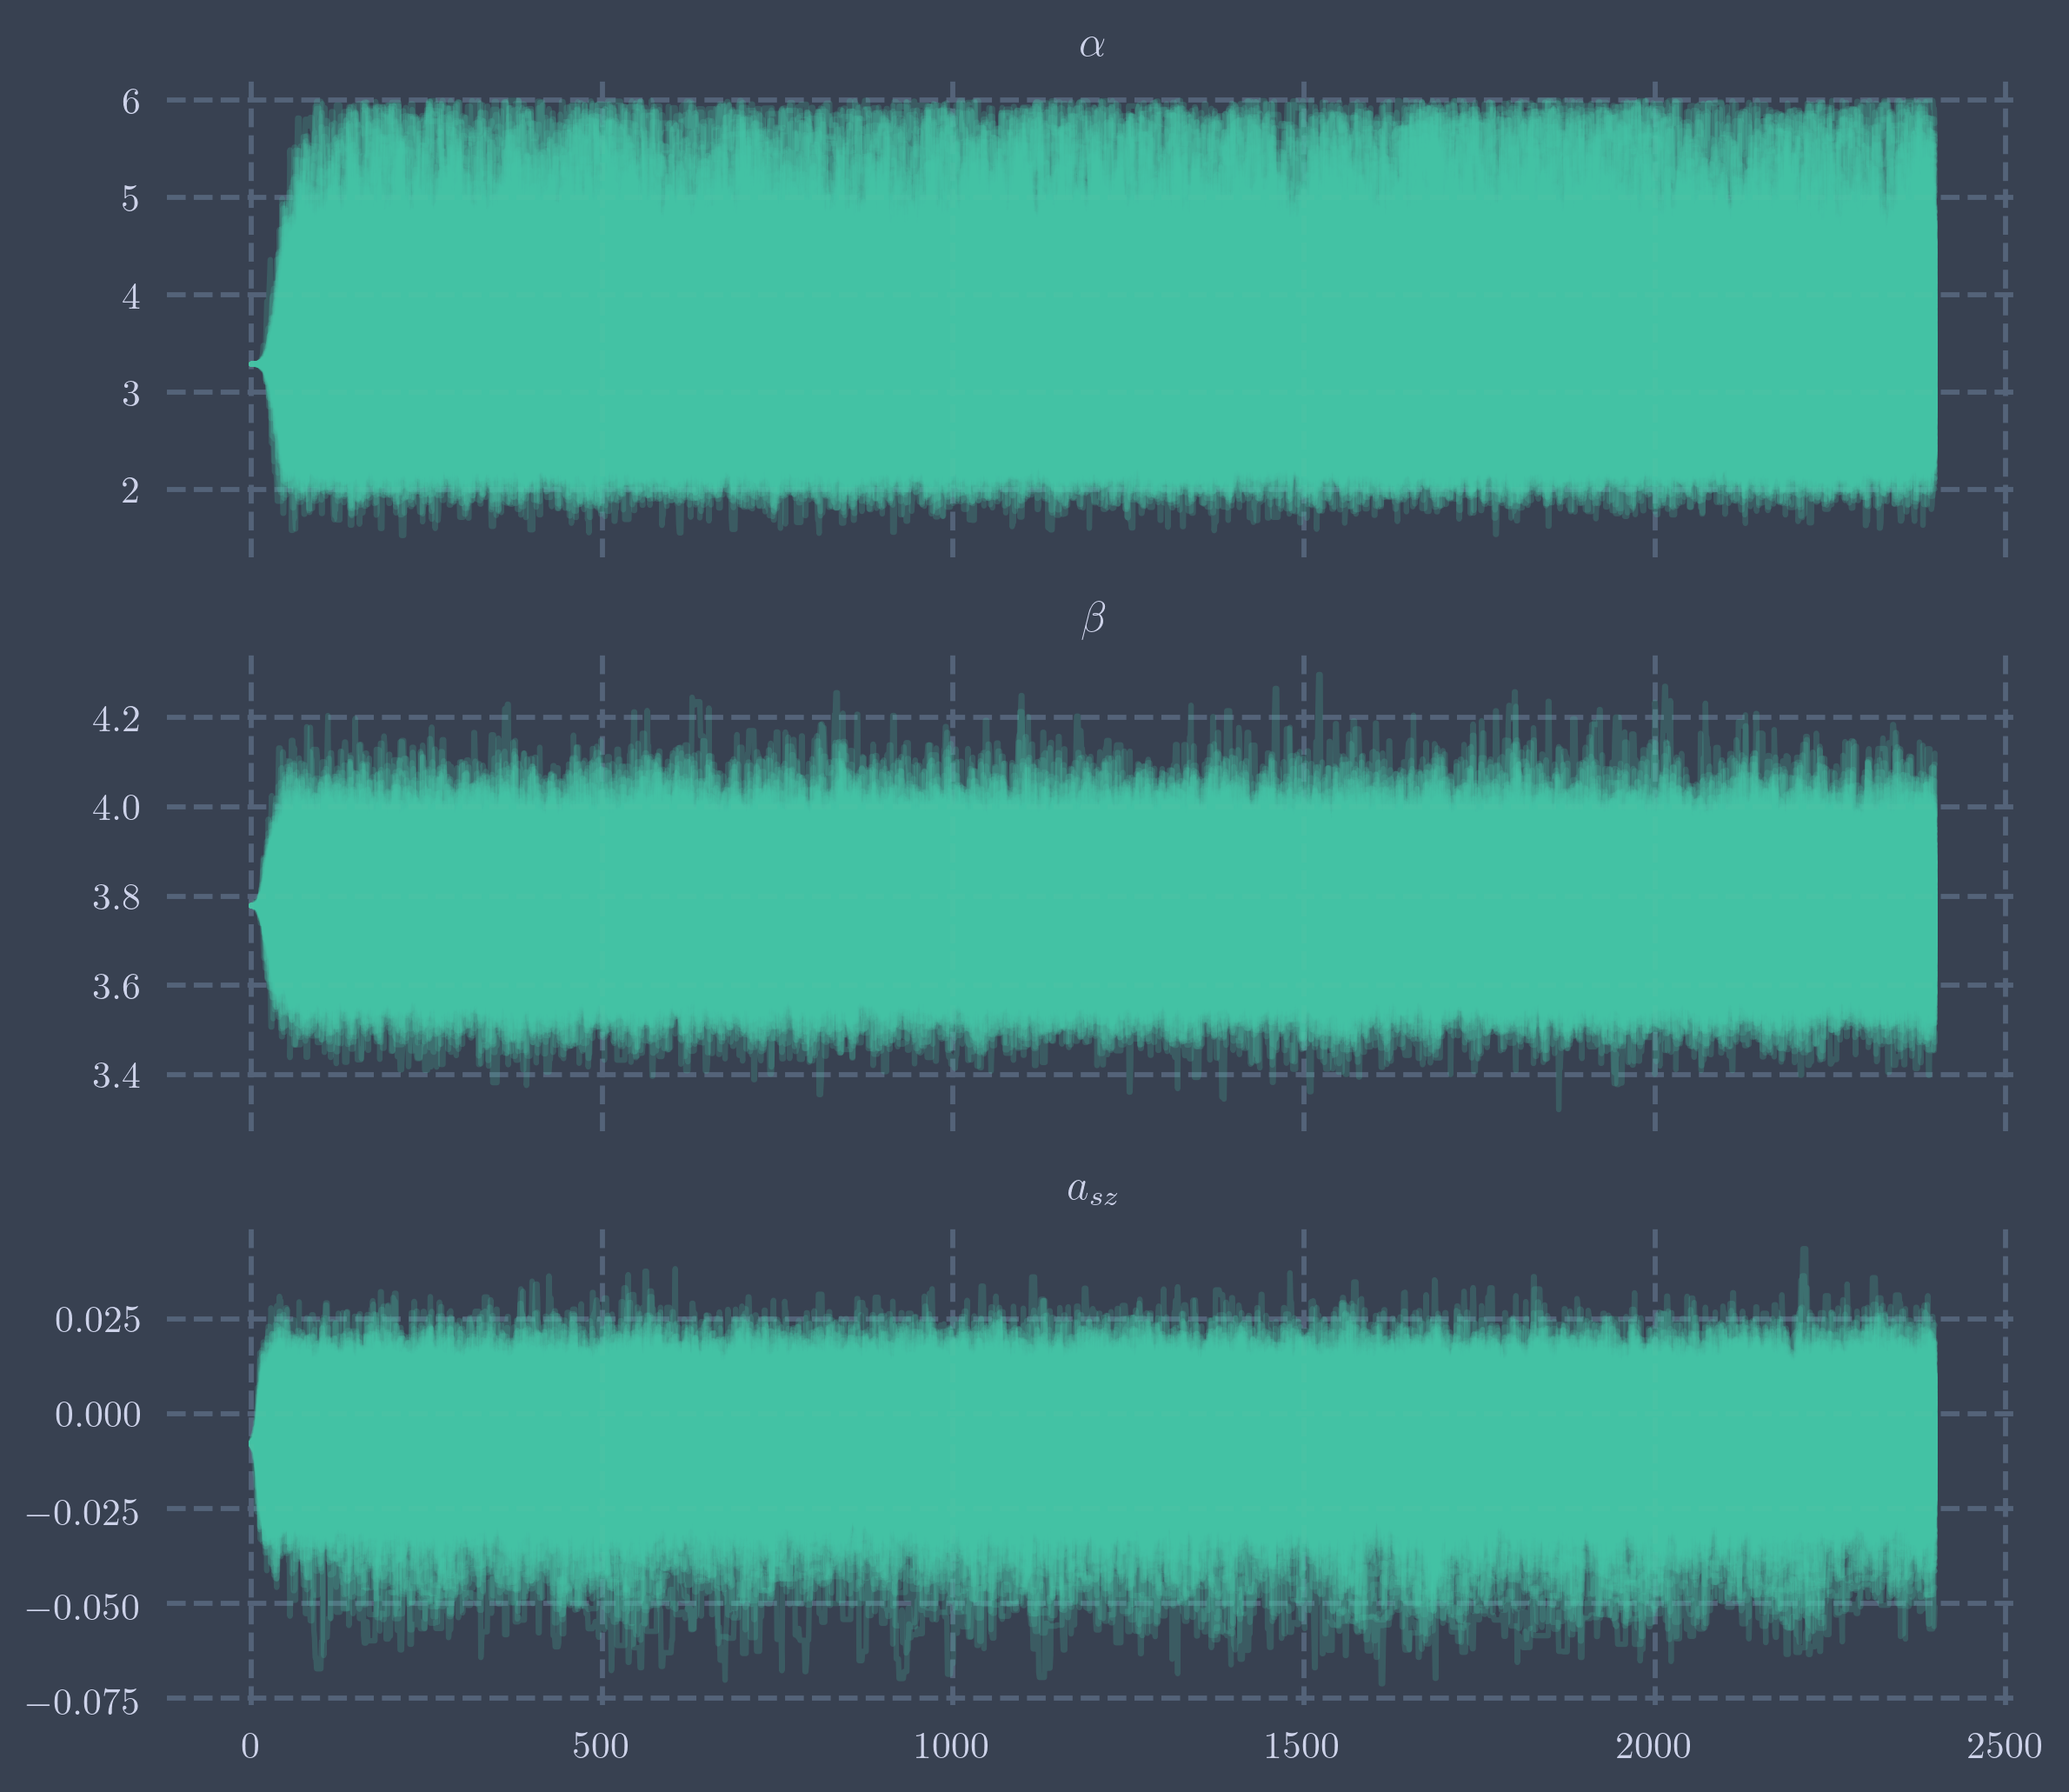

In [42]:
param_names = [r'$\alpha$', r'$\beta$', r'$a_{sz}$']
colors = ['#5b99e2', '#48c7a9']
fig,ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, color=colors[1], alpha=0.2)
    ax[i].set_title(param_names[i])

In [36]:
sampler.get_autocorr_time()

array([47.37919554, 39.52654769, 41.88712769])

In [37]:
flat_samples = sampler.get_chain(discard=400, thin=20, flat=True)

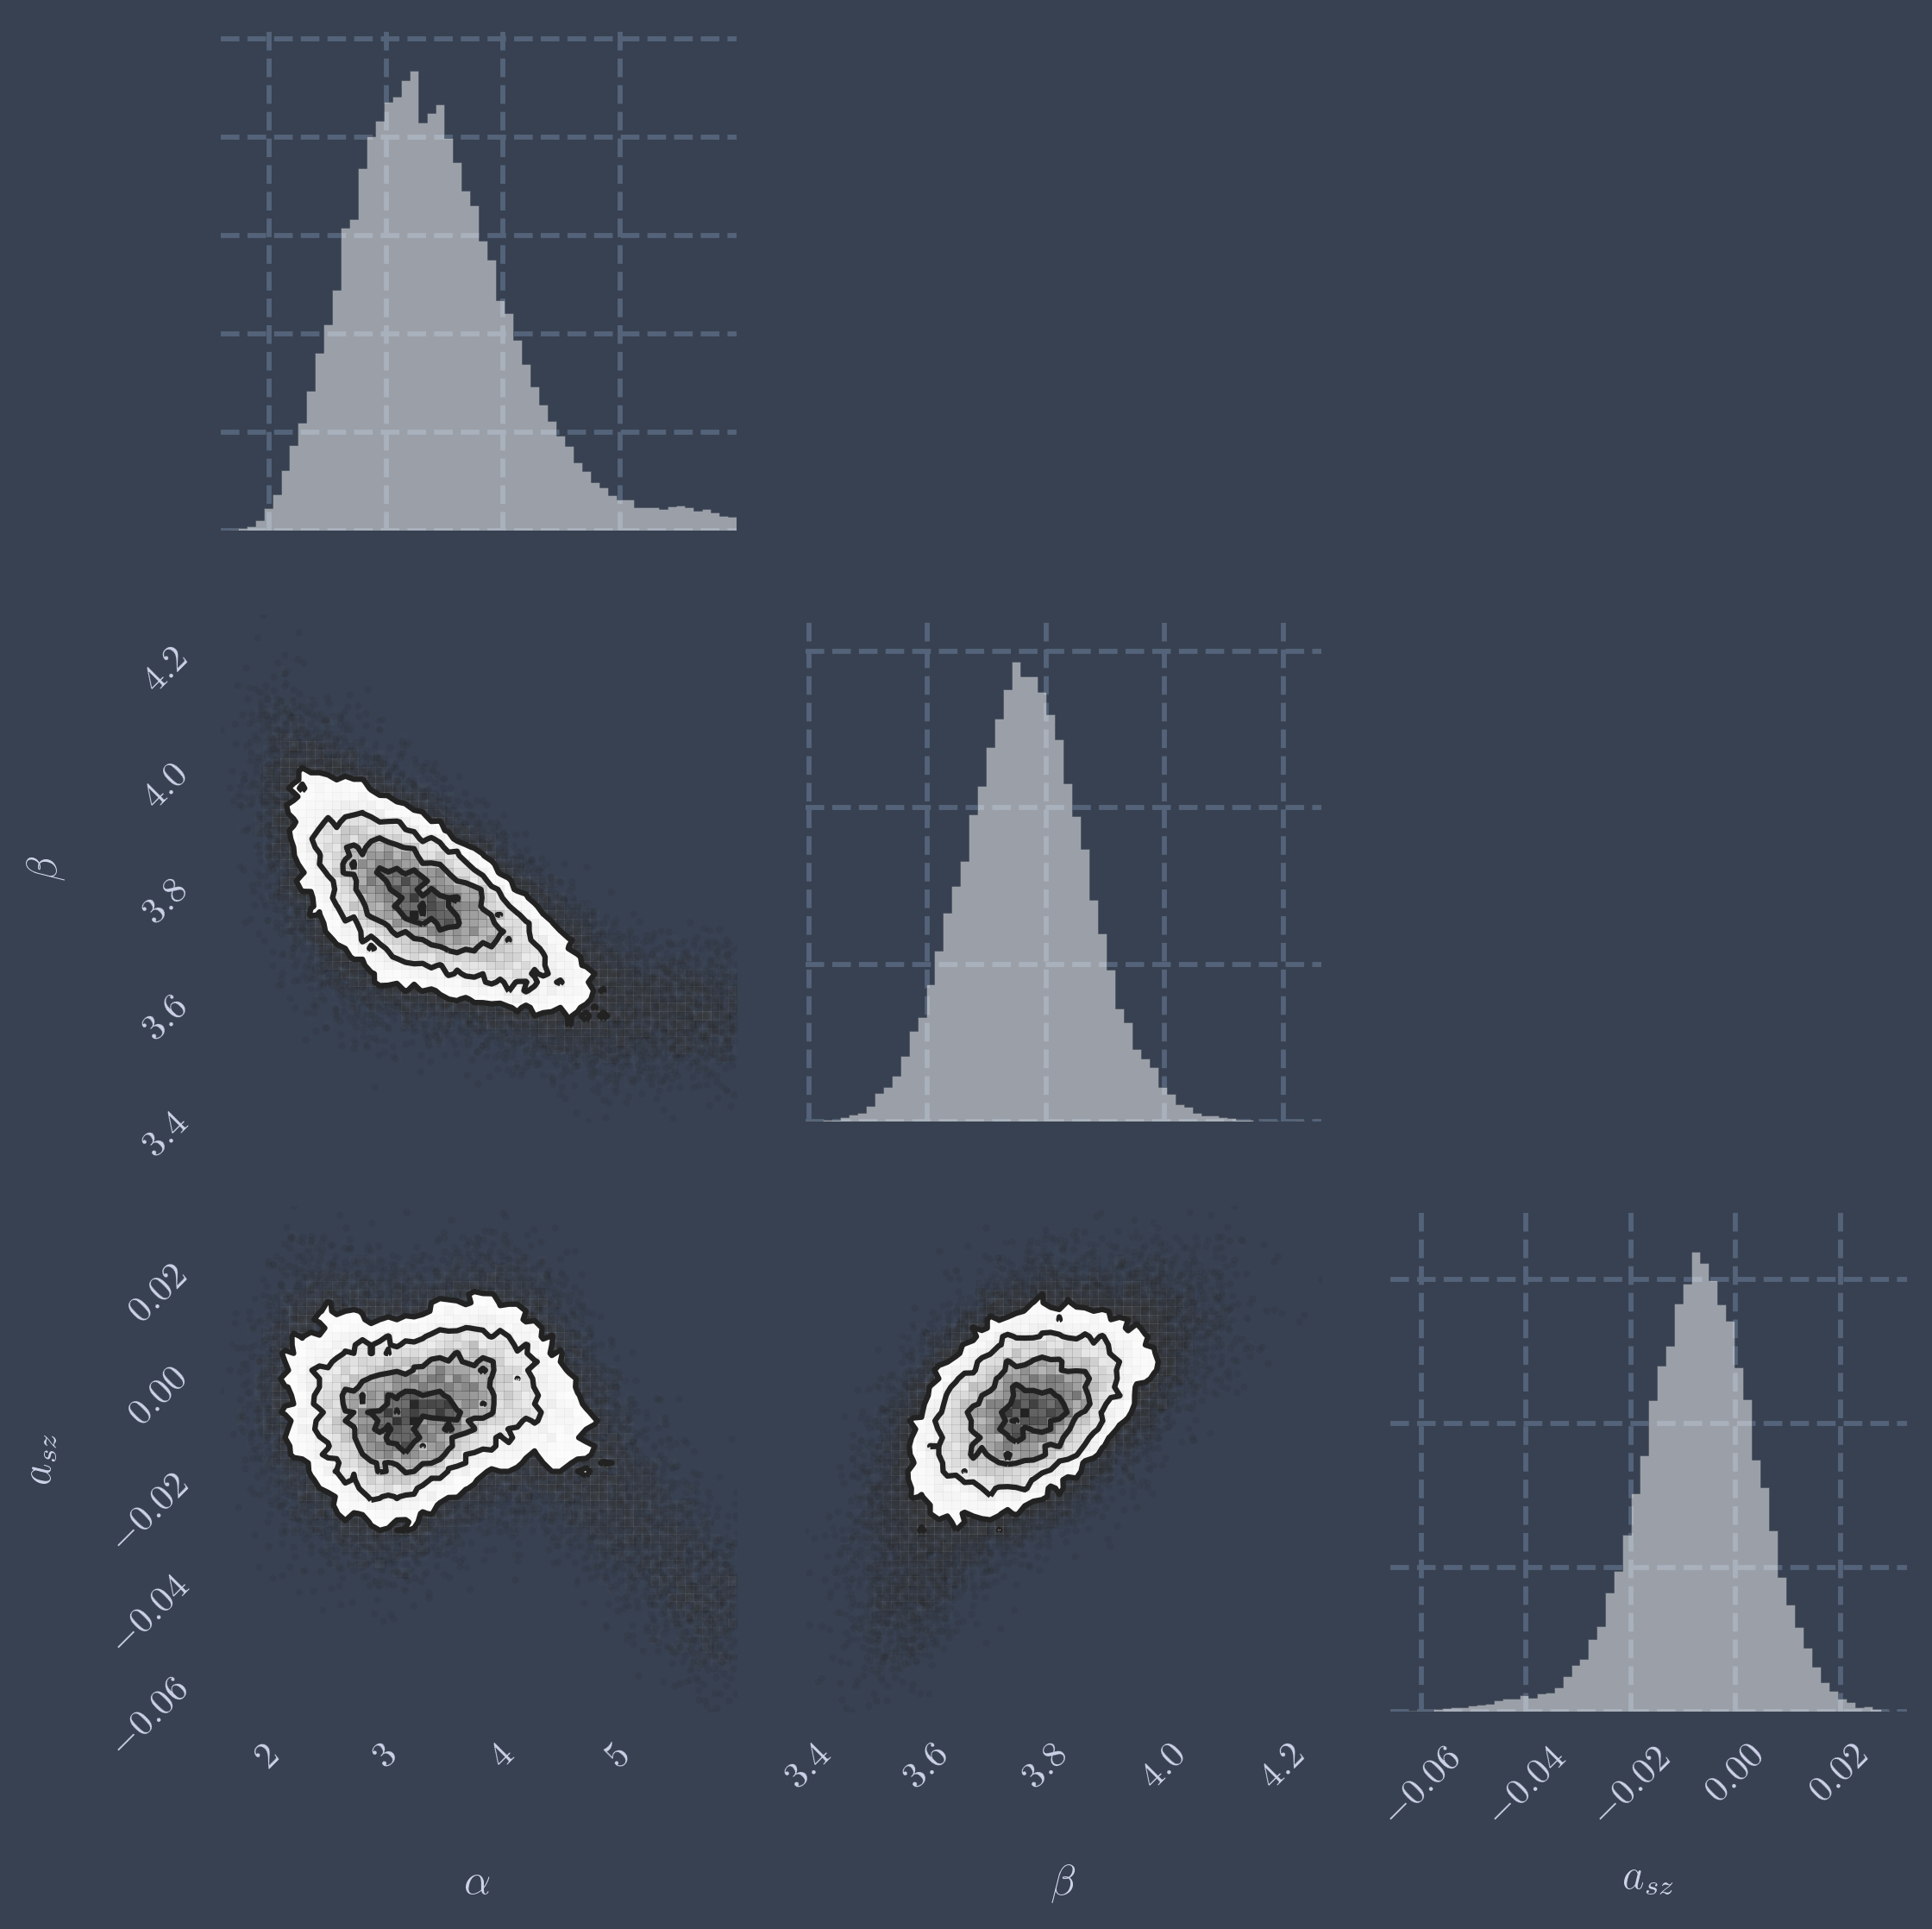

In [43]:
hist_kwargs = {'histtype':'stepfilled', 'alpha':0.5, 'color':'#ffffff'}
#hist2d_kwargs = {'cmap':cmap}
fig = corner.corner(flat_samples,
                    bins=60,
                    labels=param_names,
                    hist_kwargs=hist_kwargs)